[2024-04-11 14:37:09,677] Making new env: MountainCar-v0


E: 0.	Mean total reward across 5 rollouts: -200.0
E: 1.	Mean total reward across 5 rollouts: -200.0
E: 2.	Mean total reward across 5 rollouts: -200.0
E: 3.	Mean total reward across 5 rollouts: -200.0
E: 4.	Mean total reward across 5 rollouts: -200.0
E: 5.	Mean total reward across 5 rollouts: -200.0
E: 6.	Mean total reward across 5 rollouts: -200.0
E: 7.	Mean total reward across 5 rollouts: -200.0
E: 8.	Mean total reward across 5 rollouts: -200.0
E: 9.	Mean total reward across 5 rollouts: -200.0
E: 10.	Mean total reward across 5 rollouts: -200.0
E: 11.	Mean total reward across 5 rollouts: -200.0
E: 12.	Mean total reward across 5 rollouts: -200.0
E: 13.	Mean total reward across 5 rollouts: -200.0
E: 14.	Mean total reward across 5 rollouts: -200.0
E: 15.	Mean total reward across 5 rollouts: -200.0
E: 16.	Mean total reward across 5 rollouts: -200.0
E: 17.	Mean total reward across 5 rollouts: -200.0
E: 18.	Mean total reward across 5 rollouts: -200.0
E: 19.	Mean total reward across 5 rollout

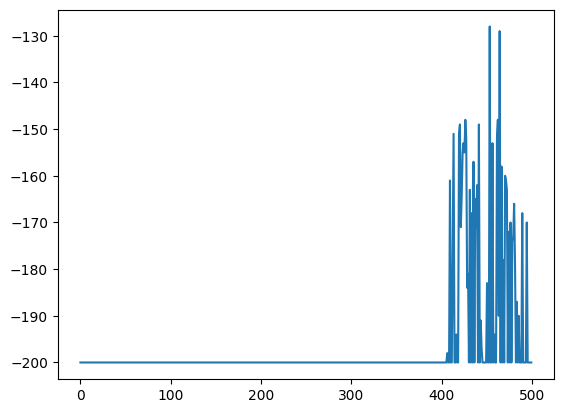

In [15]:
import gym
import numpy as np
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.distributions import Categorical
from collections import namedtuple

env = gym.make('MountainCar-v0')
env._max_episode_steps = 200

state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

Rollout = namedtuple('Rollout', ['states', 'actions', 'rewards', 'next_states', ])


def train(actor, critic, epochs=100, num_rollouts=10, render_frequency=None):
    mean_total_rewards = []
    global_rollout = 0

    for epoch in range(epochs):
        rollouts = []
        

        for t in range(num_rollouts):
            state = env.reset()
            if type(state) == tuple:
                state = state[0]
                #print(state)
            done = False
            samples = []
            rollout_total_rewards = []
            steps = 0
            while not done and steps < env._max_episode_steps:
                #if render_frequency is not None and global_rollout % render_frequency == 0:
                    #env.render()

                with torch.no_grad():
                    action = get_action(state)

                next_state, reward, done,  _ = env.step(action)

                # Collect samples
                samples.append((state, action, reward, next_state))

                state = next_state
                steps += 1

            # Transpose our samples
            states, actions, rewards, next_states = zip(*samples)
            #print(states)
            states = torch.stack([torch.from_numpy(state) for state in states], dim=0).float()
            next_states = torch.stack([torch.from_numpy(state) for state in next_states], dim=0).float()
            actions = torch.as_tensor(actions).unsqueeze(1)
            rewards = torch.as_tensor(rewards).unsqueeze(1)

            rollouts.append(Rollout(states, actions, rewards, next_states))

            rollout_total_rewards.append(rewards.sum().item())
            global_rollout += 1

        update_agent(rollouts)
        mtr = np.mean(rollout_total_rewards)
        print(f'E: {epoch}.\tMean total reward across {num_rollouts} rollouts: {mtr}')

        mean_total_rewards.append(mtr)

    plt.plot(mean_total_rewards)
    plt.show()
    return mean_total_rewards


def create_actor(state_size, action_size, hidden_size=32):
    actor_model = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size),
        nn.Softmax(dim=-1)
    )
    return actor_model

# Create critic model
def create_critic(state_size, hidden_size=32):
    critic_model = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1)
    )
    return critic_model

actor_hidden = 32
'''
actor = nn.Sequential(nn.Linear(state_size, actor_hidden),
                      nn.ReLU(),
                      nn.Linear(actor_hidden, num_actions),
                      nn.Softmax(dim = -1))
'''


def get_action(state, epsilon=0.001):
    if random.random() < epsilon:
        return random.choice(range(3))  # Assuming a discrete action space
    else:
        state = torch.tensor(state).float().unsqueeze(0)
        dist = Categorical(actor(state) / 10)
        #print(type(dist.sample().item()))
        return dist.sample().item()


# Critic takes a state and returns its values
critic_hidden = 32
'''
critic = nn.Sequential(nn.Linear(state_size, critic_hidden),
                       nn.ReLU(),
                       nn.Linear(critic_hidden, 1))
critic_optimizer = Adam(critic.parameters(), lr=0.01)
'''

def update_critic(advantages):
    loss = .5 * (advantages ** 2).mean()  # MSE
    critic_optimizer.zero_grad()
    loss.backward()
    critic_optimizer.step()


# delta, maximum KL divergence
max_d_kl = 0.01


def update_agent(rollouts):
    states = torch.cat([r.states for r in rollouts], dim=0)
    actions = torch.cat([r.actions for r in rollouts], dim=0).flatten()

    advantages = [estimate_advantages(states, next_states[-1], rewards) for states, _, rewards, next_states in rollouts]
    advantages = torch.cat(advantages, dim=0).flatten()

    # Normalize advantages to reduce skewness and improve convergence
    advantages = (advantages - advantages.mean()) / advantages.std()

    update_critic(advantages)

    distribution = actor(states)
    distribution = torch.distributions.utils.clamp_probs(distribution)
    probabilities = distribution[range(distribution.shape[0]), actions]


    # Now we have all the data we need for the algorithm

    # We will calculate the gradient wrt to the new probabilities (surrogate function),
    # so second probabilities should be treated as a constant
    L = surrogate_loss(probabilities, probabilities.detach(), advantages) 
    KL = kl_div(distribution, distribution)

    parameters = list(actor.parameters())

    g = flat_grad(L, parameters, retain_graph=True)
    d_kl = flat_grad(KL, parameters, create_graph=True)  # Create graph, because we will call backward() on it (for HVP)

    def HVP(v):
        return flat_grad(d_kl @ v, parameters, retain_graph=True)

    search_dir = conjugate_gradient(HVP, g)
    max_length = torch.sqrt(2 * max_d_kl / (search_dir @ HVP(search_dir)))
    max_step = max_length * search_dir

    def criterion(step):
        apply_update(step)

        with torch.no_grad():
            distribution_new = actor(states)
            distribution_new = torch.distributions.utils.clamp_probs(distribution_new)
            probabilities_new = distribution_new[range(distribution_new.shape[0]), actions]

            L_new = surrogate_loss(probabilities_new, probabilities, advantages)
            KL_new = kl_div(distribution, distribution_new)

        L_improvement = L_new - L

        if L_improvement > 0 and KL_new <= max_d_kl:
            return True

        apply_update(-step)
        return False

    i = 0
    while not criterion((0.9 ** i) * max_step) and i < 10:
        i += 1


def estimate_advantages(states, last_state, rewards):
    values = critic(states)
    last_value = critic(last_state.unsqueeze(0))
    next_values = torch.zeros_like(rewards)
    for i in reversed(range(rewards.shape[0])):
        last_value = next_values[i] = rewards[i] + 0.99 * last_value
    advantages = next_values - values
    return advantages


def surrogate_loss(new_probabilities, old_probabilities, advantages):
    return (new_probabilities / old_probabilities * advantages).mean()


def kl_div(p, q):
    p = p.detach()
    return (p * (p.log() - q.log())).sum(-1).mean()


def flat_grad(y, x, retain_graph=False, create_graph=False):
    if create_graph:
        retain_graph = True

    g = torch.autograd.grad(y, x, retain_graph=retain_graph, create_graph=create_graph)
    g = torch.cat([t.view(-1) for t in g])
    return g


def conjugate_gradient(A, b, delta=0., max_iterations=10):
    x = torch.zeros_like(b)
    r = b.clone()
    p = b.clone()

    i = 0
    while i < max_iterations:
        AVP = A(p)

        dot_old = r @ r
        alpha = dot_old / (p @ AVP)

        x_new = x + alpha * p

        if (x - x_new).norm() <= delta:
            return x_new

        i += 1
        r = r - alpha * AVP

        beta = (r @ r) / dot_old
        p = r + beta * p

        x = x_new
    return x


def apply_update(grad_flattened):
    n = 0
    for p in actor.parameters():
        numel = p.numel()
        g = grad_flattened[n:n + numel].view(p.shape)
        p.data += g
        n += numel

#a = train(epochs=500, num_rollouts=5, render_frequency=50)

# Train our agent
trials = 3
results = []

actor = create_actor(state_size, num_actions)
critic = create_critic(state_size)
critic_optimizer = Adam(critic.parameters(), lr=0.01)
results.append(train(actor, critic, epochs=500, num_rollouts=5, render_frequency=50))




E: 0.	Mean total reward across 5 rollouts: -200.0
E: 1.	Mean total reward across 5 rollouts: -200.0
E: 2.	Mean total reward across 5 rollouts: -200.0
E: 3.	Mean total reward across 5 rollouts: -200.0
E: 4.	Mean total reward across 5 rollouts: -200.0
E: 5.	Mean total reward across 5 rollouts: -200.0
E: 6.	Mean total reward across 5 rollouts: -200.0
E: 7.	Mean total reward across 5 rollouts: -200.0
E: 8.	Mean total reward across 5 rollouts: -200.0
E: 9.	Mean total reward across 5 rollouts: -200.0
E: 10.	Mean total reward across 5 rollouts: -200.0
E: 11.	Mean total reward across 5 rollouts: -200.0
E: 12.	Mean total reward across 5 rollouts: -200.0
E: 13.	Mean total reward across 5 rollouts: -200.0
E: 14.	Mean total reward across 5 rollouts: -200.0
E: 15.	Mean total reward across 5 rollouts: -200.0
E: 16.	Mean total reward across 5 rollouts: -200.0
E: 17.	Mean total reward across 5 rollouts: -200.0
E: 18.	Mean total reward across 5 rollouts: -200.0
E: 19.	Mean total reward across 5 rollout

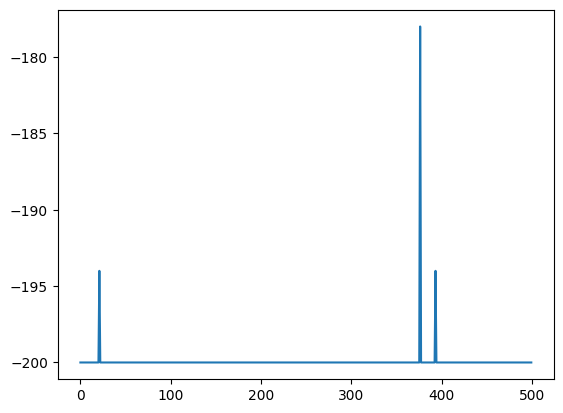

In [48]:
actor = create_actor(state_size, num_actions)
critic = create_critic(state_size)
critic_optimizer = Adam(critic.parameters(), lr=0.01)
results.append(train(actor, critic, epochs=500, num_rollouts=5, render_frequency=50))

In [21]:
results = results[:-1]

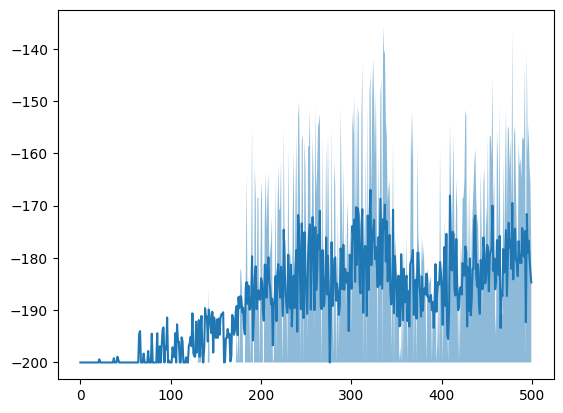

In [49]:
#print(results)
mean = np.mean(results, axis = 0)
par_1_75, par_1_25 = np.percentile(results, [75, 25], axis = 0)
plt.plot(mean)
plt.fill_between(range(500), par_1_25, par_1_75, alpha = 0.5)

In [50]:
import pickle
dataStore = {}

dataStore['TRPO'] = results
    
with open('./' + 'Results_TRPO_MC_200' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file
